<a href="https://colab.research.google.com/github/sanjaydinesh19/lstm-footwear-analysis/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Drive Mount

In [3]:

print("Mounting Google Drive")
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
except Exception as e:
    print("Drive mount skipped or failed:", e)

CSV_PATH = "/content/drive/MyDrive/Research/Time Series Footwear/data.csv"
print("CSV_PATH =", CSV_PATH)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


Mounting Google Drive
Mounted at /content/drive
CSV_PATH = /content/drive/MyDrive/Research/Time Series Footwear/data.csv


# 2. Install Prophet

In [4]:
!pip install --quiet prophet

# 3. Imports and Helpers

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def print_eval(y_true, y_pred, label="Evaluation"):
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", rmse(y_true, y_pred))
    print("MAPE:", mape(y_true, y_pred))
    print("Accuracy:" ,100 - mape(y_true,y_pred))
    print()

# 4. Load CSV and Inspect

In [8]:
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)
display(df.head(10))
DATE_COL = 'week_end_date'
VALUE_COL = 'units_sold'
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df = df.dropna(subset=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
print("New Shape:", df.shape)
display(df[[DATE_COL, VALUE_COL]].head(10))

Initial shape: (8000, 13)


,week_end_date,store_id,product_id,units_sold,units_returned,unit_price_inr,revenue_inr,promo_flag,discount_rate,avg_temp_c,rainfall_mm,neighborhood_trend_index,is_festival_season
0,2024-01-07,ST01,P001,24,2,2038,48912,0,0.15,28.8,31.5,95.3,1
1,2024-01-07,ST01,P002,20,2,1547,30940,0,0.00,26.7,12.0,98.8,1
2,2024-01-07,ST01,P003,15,4,2328,34920,0,0.00,24.4,34.2,102.9,1
3,2024-01-07,ST01,P004,21,0,3053,64113,0,0.00,24.3,13.3,115.2,1
4,2024-01-07,ST01,P005,12,2,961,11532,0,0.20,23.8,37.8,107.9,1
5,2024-01-07,ST01,P006,25,2,1563,39075,0,0.00,30.9,7.3,94.9,1
6,2024-01-07,ST01,P007,16,2,2498,39968,0,0.00,26.0,29.0,91.0,1
7,2024-01-07,ST01,P008,17,2,2695,45815,0,0.00,25.4,24.9,99.2,1
8,2024-01-07,ST01,P009,20,3,2681,53620,0,0.00,25.8,15.5,100.9,1
9,2024-01-07,ST01,P010,24,5,2522,60528,0,0.15,21.6,0.0,108.9,1


New Shape: (8000, 13)


,week_end_date,units_sold
0,2024-01-07,24
1,2024-01-07,10
2,2024-01-07,25
3,2024-01-07,21
4,2024-01-07,11
5,2024-01-07,22
6,2024-01-07,13
7,2024-01-07,20
8,2024-01-07,25
9,2024-01-07,12


# 5. Prepare Prophet DataFrame

Prophet DataFrame head and tail:


,ds,y
0,2024-01-07,24
1,2024-01-07,10
2,2024-01-07,25
3,2024-01-07,21
4,2024-01-07,11


,ds,y
7995,2025-07-13,22
7996,2025-07-13,20
7997,2025-07-13,19
7998,2025-07-13,27
7999,2025-07-13,17


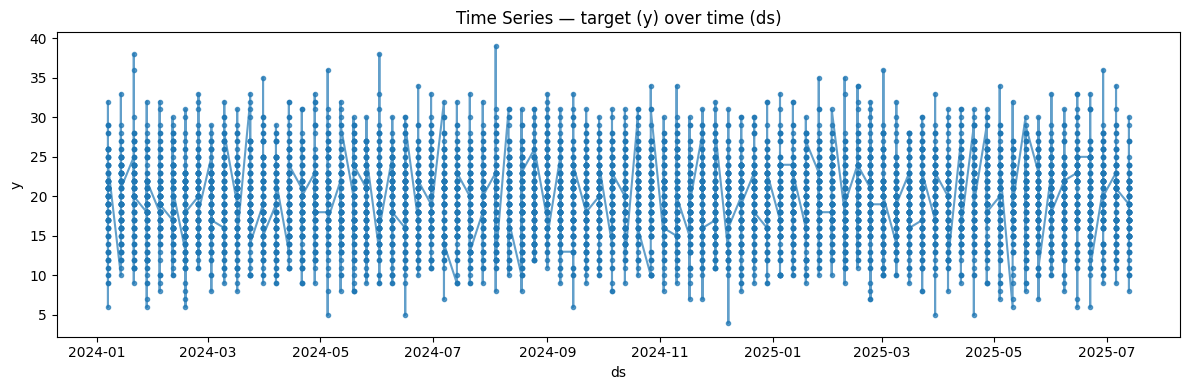

In [9]:
df_prophet = df[[DATE_COL, VALUE_COL]].rename(columns={DATE_COL: 'ds', VALUE_COL: 'y'}).copy()
# Prophet requires numeric y; ensure dtype
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
df_prophet = df_prophet.dropna(subset=['y']).reset_index(drop=True)

print("Prophet DataFrame head and tail:")
display(df_prophet.head())
display(df_prophet.tail())

plt.figure(figsize=(12,4))
plt.plot(df_prophet['ds'], df_prophet['y'], linestyle='-', marker='.', alpha=0.7)
plt.title("Time Series — target (y) over time (ds)")
plt.xlabel("ds")
plt.ylabel("y")
plt.tight_layout()
plt.show()


# 6. Train/Test Split

In [10]:
# We use last 10% for test.
test_frac = 0.10
n = len(df_prophet)
test_n = max(1, int(np.round(n * test_frac)))
train_n = n - test_n

train_df = df_prophet.iloc[:train_n].copy()
test_df  = df_prophet.iloc[train_n:].copy()

print(f"Total rows: {n} | Train: {train_n} | Test: {test_n}")
display(train_df.tail())
display(test_df.head())


Total rows: 8000 | Train: 7200 | Test: 800


,ds,y
7195,2025-05-18,19
7196,2025-05-18,21
7197,2025-05-18,15
7198,2025-05-18,15
7199,2025-05-18,29


,ds,y
7200,2025-05-25,23
7201,2025-05-25,17
7202,2025-05-25,25
7203,2025-05-25,20
7204,2025-05-25,25


# 7. Basic Prophet Model

In [13]:
m = Prophet(
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality=False,
    changepoint_prior_scale=0.2,
    seasonality_mode='additive'
)
m.fit(train_df)
print("Model fitted.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/db8q05bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/cgtek85p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20190', 'data', 'file=/tmp/tmpo5h8b897/db8q05bt.json', 'init=/tmp/tmpo5h8b897/cgtek85p.json', 'output', 'file=/tmp/tmpo5h8b897/prophet_model5ytmfs0w/prophet_model-20251024140542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:05:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model fitted.


# 8. Forecast on Test Set

In [18]:
future = m.make_future_dataframe(periods=test_n, freq=None)  # freq inferred from ds
print("Future frame length:", len(future))
forecast = m.predict(future)

# Show forecast tail (predictions for test period)
pred_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    df_prophet[['ds','y']], on='ds', how='left'
)
display(pred_df.tail(2*test_n))

# Evaluate on the test period
eval_df = pred_df.dropna(subset=['y']).iloc[-test_n:].copy()
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values
print_eval(y_true, y_pred, label="Prophet — test set evaluation")


Future frame length: 872


,ds,yhat,yhat_lower,yhat_upper,y
7192,2025-05-18,19.407838,13.019023,25.370019,21.0
7193,2025-05-18,19.407838,13.019023,25.370019,23.0
7194,2025-05-18,19.407838,13.019023,25.370019,22.0
7195,2025-05-18,19.407838,13.019023,25.370019,19.0
7196,2025-05-18,19.407838,13.019023,25.370019,21.0
...,...,...,...,...,...
8787,2040-08-19,15.205798,5.048057,25.931393,NaN
8788,2040-08-26,15.200519,5.809470,25.513737,NaN
8789,2040-09-02,15.195240,6.088982,26.288690,NaN
8790,2040-09-09,15.189961,4.503631,25.446975,NaN


MAE : 3.7166244792178134
RMSE: 4.6830570137167555
MAPE: 21.391721279238162
Accuracy: 78.60827872076183



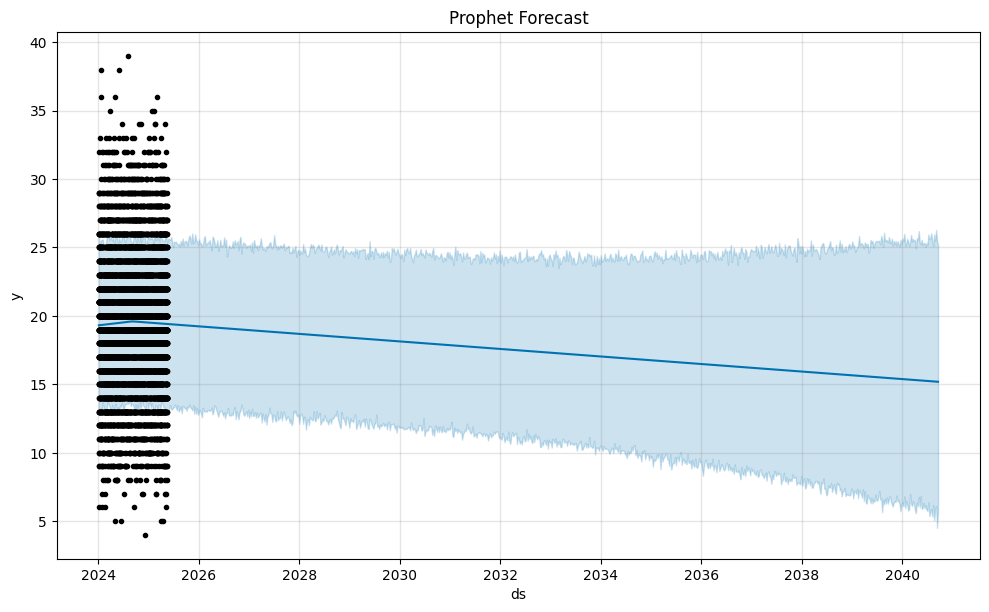

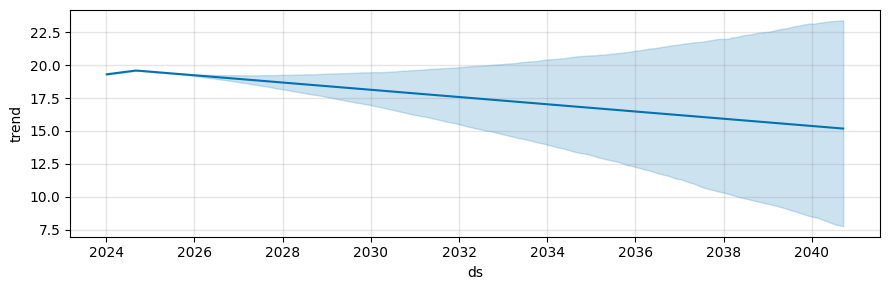

In [19]:
fig = m.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("ds")
plt.ylabel("y")
plt.show()
fig_comp = m.plot_components(forecast)
plt.show()



# 9. Cross Validation

In [21]:
from prophet.diagnostics import cross_validation, performance_metrics
data_span_days = (df_prophet['ds'].max() - df_prophet['ds'].min()).days
print("Total span in days:", data_span_days)
df_cv = cross_validation(
    model=m,
    initial=f"{int(data_span_days * 0.6)} days",  # first 60% train
    period=f"{int(data_span_days * 0.1)} days",   # step ahead 10%
    horizon=f"{int(data_span_days * 0.2)} days"   # predict next 20%
)

df_p = performance_metrics(df_cv)
print("Cross-validation metrics summary:")
display(df_p.head())


INFO:prophet:Making 2 forecasts with cutoffs between 2024-12-04 00:00:00 and 2025-01-28 00:00:00


Total span in days: 553


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/s_bttt8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/fnx_yn7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40823', 'data', 'file=/tmp/tmpo5h8b897/s_bttt8o.json', 'init=/tmp/tmpo5h8b897/fnx_yn7i.json', 'output', 'file=/tmp/tmpo5h8b897/prophet_model7iqnn6_e/prophet_model-20251024141107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/d2c18wvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/sncqhmly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Cross-validation metrics summary:


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,21.936923,4.683687,3.817814,0.226647,0.154022,0.203328,0.806875
1,18 days,22.179514,4.709513,3.809370,0.227207,0.150340,0.203434,0.799375
2,19 days,22.621367,4.756192,3.800765,0.214798,0.150005,0.198328,0.803750
3,25 days,21.695105,4.657800,3.709555,0.205015,0.150005,0.191408,0.816875
4,26 days,23.185014,4.815082,3.811054,0.214951,0.150244,0.197154,0.810000


# 10. Add Exogenous Features

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/1vi96oez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/ozcz5w35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41704', 'data', 'file=/tmp/tmpo5h8b897/1vi96oez.json', 'init=/tmp/tmpo5h8b897/ozcz5w35.json', 'output', 'file=/tmp/tmpo5h8b897/prophet_modelwx_peujn/prophet_model-20251024143948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


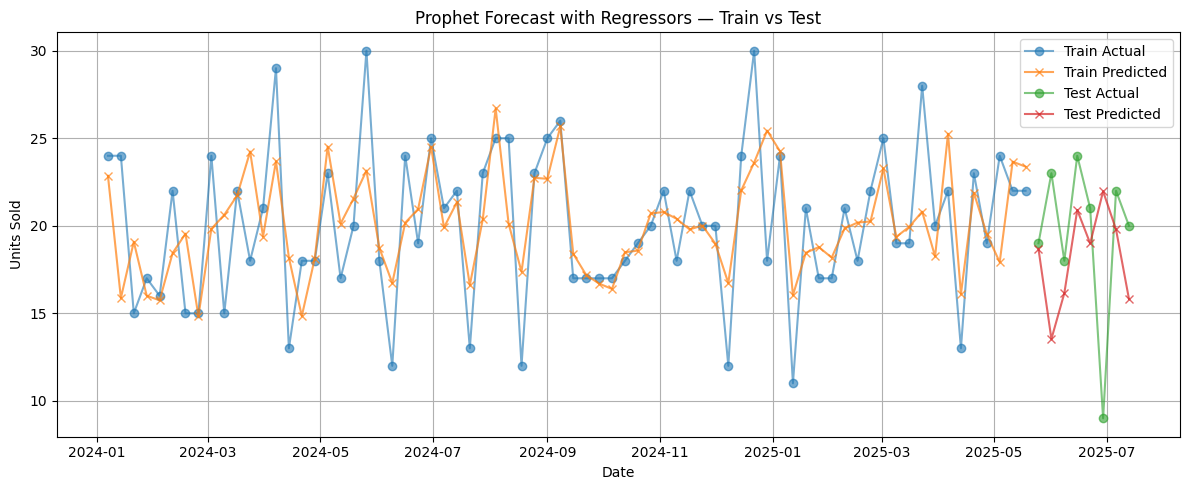

Training Metrics
MAE:  2.4825170525469775
RMSE:  3.263328152757007
MAPE:  13.285267241139831
Accuracy: 86.71473275886017
Testing Metrics
MAE:  4.51260804680367
RMSE:  6.096405787247141
MAPE:  31.330393683211316
Accuracy: 68.66960631678869


In [39]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

sub = df[(df['store_id']=='ST01') & (df['product_id']=='P001')].copy()
EXOG_COLS = [
    'units_returned',
    'unit_price_inr',
    'promo_flag',
    'discount_rate',
    'avg_temp_c',
    'rainfall_mm',
    'neighborhood_trend_index',
    'is_festival_season'
]

df_prophet = sub.rename(columns={'week_end_date':'ds','units_sold':'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=5
)
for reg in EXOG_COLS:
    if df_prophet[reg].nunique() > 1:
        m.add_regressor(reg,prior_scale =0.5)

m.fit(train_df)

future = m.make_future_dataframe(periods=len(test_df), freq='W')
for reg in EXOG_COLS:
    if reg in df_prophet.columns:
        future[reg] = df_prophet[reg].iloc[:len(future)].ffill().iloc[-len(future):].reset_index(drop=True)

forecast = m.predict(future)

merged = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    df_prophet[['ds', 'y']], on='ds', how='left'
).dropna(subset=['y'])

train_merged = merged.iloc[:train_size]
test_merged = merged.iloc[train_size:]

def metrics(df):
    y_true = df['y'].values
    y_pred = df['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    accuracy = 100 - mape
    return mae, rmse, mape, accuracy

train_mae, train_rmse, train_mape, train_acc = metrics(train_merged)
test_mae, test_rmse, test_mape, test_acc = metrics(test_merged)

plt.figure(figsize=(12,5))
plt.plot(train_merged['ds'], train_merged['y'], label='Train Actual', marker='o', alpha=0.6)
plt.plot(train_merged['ds'], train_merged['yhat'], label='Train Predicted', marker='x', alpha=0.7)
plt.plot(test_merged['ds'], test_merged['y'], label='Test Actual', marker='o', alpha=0.6)
plt.plot(test_merged['ds'], test_merged['yhat'], label='Test Predicted', marker='x', alpha=0.7)
plt.title('Prophet Forecast with Regressors — Train vs Test')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Training Metrics")
print("MAE: ",train_mae)
print("RMSE: ",train_rmse)
print("MAPE: ",train_mape)
print("Accuracy:" ,train_acc)
print("Testing Metrics")
print("MAE: ",test_mae)
print("RMSE: ",test_rmse)
print("MAPE: ",test_mape)
print("Accuracy:" ,test_acc)


# 11. Hyperparameter Tuning

In [35]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import itertools

sub = df[(df['store_id']=='ST01') & (df['product_id']=='P001')].copy()
EXOG_COLS = [
    'units_returned',
    'unit_price_inr',
    'promo_flag',
    'discount_rate',
    'avg_temp_c',
    'rainfall_mm',
    'neighborhood_trend_index',
    'is_festival_season'
]

df_prophet = sub.rename(columns={'week_end_date':'ds','units_sold':'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.3],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []

for params in all_params:
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        changepoint_range=params['changepoint_range']
    )

    for reg in EXOG_COLS:
        if df_prophet[reg].nunique() > 1:
            m.add_regressor(reg, prior_scale=0.5)

    m.fit(train_df)

    future = m.make_future_dataframe(periods=len(test_df), freq='W')

    for reg in EXOG_COLS:
        col = df_prophet[reg].copy()
        col = col.ffill().bfill()
        ext = col.iloc[-len(test_df):].reset_index(drop=True)
        if len(ext) < len(test_df):
            ext = ext.append(pd.Series([ext.mean()] * (len(test_df) - len(ext))), ignore_index=True)
        future[reg] = pd.concat([col, ext], ignore_index=True)[:len(future)]
        future[reg] = future[reg].fillna(future[reg].mean())

    forecast = m.predict(future)
    merged = forecast[['ds', 'yhat']].merge(df_prophet[['ds','y']], on='ds', how='left').dropna(subset=['y'])

    y_true = merged['y'].iloc[train_size:].values
    y_pred = merged['yhat'].iloc[train_size:].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    acc = 100 - mape

    results.append({
        **params,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': acc
    })

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df.head(10)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/3zoo9qlz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h8b897/pjearrqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=851', 'data', 'file=/tmp/tmpo5h8b897/3zoo9qlz.json', 'init=/tmp/tmpo5h8b897/pjearrqm.json', 'output', 'file=/tmp/tmpo5h8b897/prophet_modelldea5240/prophet_model-20251024143315.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo5h

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,changepoint_range,MAE,RMSE,MAPE,Accuracy
0,0.10,1.0,multiplicative,0.90,4.479107,6.079875,31.186784,68.813216
1,0.05,10.0,multiplicative,0.80,4.473888,6.085444,31.187630,68.812370
2,0.10,1.0,multiplicative,0.80,4.491189,6.088281,31.243663,68.756337
3,0.30,1.0,multiplicative,0.95,4.492413,6.089634,31.251424,68.748576
4,0.30,1.0,multiplicative,0.80,4.494433,6.090173,31.258792,68.741208
5,0.10,1.0,multiplicative,0.95,4.495931,6.090370,31.264232,68.735768
6,0.30,1.0,multiplicative,0.90,4.498423,6.090461,31.271569,68.728431
7,0.05,1.0,multiplicative,0.95,4.502824,6.091736,31.287275,68.712725
8,0.05,5.0,multiplicative,0.90,4.500525,6.094668,31.290404,68.709596
9,0.10,10.0,multiplicative,0.80,4.502173,6.093505,31.290889,68.709111
